In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split

# WHAT ARE THE DIFFERENCES BETWEEN PCA and a VAE with linear activation functions?

PCA is one one the most used analytical tools to perform multivariate analysis. Despite its strengths, one of the supposed limits is that the scores are a linear combinations of input variables. VAE on the other hand are a powerful tool composed of a encoder-decoder structure in which there's the freedom of selecting the activation function inside the neural network. So what happens if we decide to keep the activation function linear? Are the results from a VAE and PCA comparable? If so, up to which point?
In the following we will load a standard dataset and we will explore the results from PCA and from VAE.

# PCA

The Dataset is the load_breast_cancer from sklearn with 569 samples and 30 columns. We will try to reduce the dimensions of this dataset with PCA comparing a "from scratch" approach using numpy libraries and then the implementation of sklearn.

In [35]:
X, y = datasets.load_breast_cancer(return_X_y=True,as_frame=True)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
X.shape

(569, 30)

In [106]:
from sklearn.preprocessing import StandardScaler

to apply PCA our variables must be center-scaled. If we have different unit measures we should always also scale the data. The common way to do so is to use z-scaling.

In [117]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_std = (X-np.mean(X))/np.std(X)

We will use Singular Value Decomposition (SVD) from numpy. SVD is a factorization of a 2D matrix A. it is written as:
$$ A = USV^H $$
S is a 1D array which contains the singular values of a; u and vh are unitary ($U^TU$ = $UU^T$ = I).
Most PCA implementation perform SVD to improve computational efficiency.

In [237]:
u, s, vh = np.linalg.svd(X_std,full_matrices=False)
n_samples, n_features = X_std.shape
u.shape, s.shape, vh.shape

((569, 30), (30,), (30, 30))

The covariance matrix is a dxd matrix where each element represent the covariance between two features. the diagonal values are just the variance of the variable.
$$ \Sigma = \frac{1}{(n-1)} \left( (X-x)^T (X-x)\right) $$

in numpy np.cov if rowvar is True (default), then each row represents a variable, with observations in the columns. Otherwise, the relationship is transposed: each column represents a variable, while the rows contain observations.

In [238]:
# unitary matrix vh@vh.T
CovA = np.cov(X_std.T)
CovA.shape

(30, 30)

In [239]:
print(CovA[:2])

[[ 1.00176056  0.32435193  0.99961207  0.98909547  0.17088151  0.50701464
   0.67795504  0.82397664  0.14800135 -0.31217947  0.68028597 -0.09748878
   0.67535854  0.7371592  -0.22299203  0.20636266  0.19454553  0.37683123
  -0.10450454 -0.04271634  0.97124591  0.29753054  0.9668357   0.94273929
   0.11982673  0.41419075  0.52783912  0.74552443  0.16424199  0.00707833]
 [ 0.32435193  1.00176056  0.33011322  0.32165099 -0.02342969  0.23711895
   0.30295025  0.29398071  0.07152669 -0.07657176  0.27635436  0.38703783
   0.28216902  0.26030246  0.00662542  0.19231259  0.14354535  0.1641395
   0.00914324  0.0545534   0.35319367  0.9136503   0.35866993  0.34415078
   0.07763981  0.27831873  0.3015552   0.29583577  0.10519278  0.11941522]]


eigendecomposition on the covariance matrix: $SP = P\lambda$ where P will be our loadings (eigenvectors) and $\lambda$ the eigenvalues.

In [240]:
eig_vals, eig_vecs = np.linalg.eig(CovA)
eig_vals.shape, eig_vecs.shape

((30,), (30, 30))

In [241]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

In [242]:
np.linalg.norm(eig_vecs.T[0])

0.9999999999999999

To decide which eigenvector we want to keep, we need to inspect the corresponding eigenvalues: the eigenvectors with lowest eigenvalues has the least information about the variance of the original data. The common approach is to rank the eigenvalues from highes to lowest in order to choose the top $k$ eigenvectors.

In [243]:
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in eig_vals]
cum_var_exp = np.cumsum(var_exp)

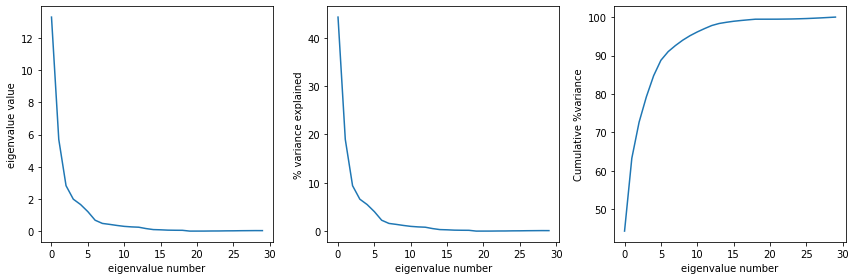

In [244]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(eig_vals)
plt.xlabel('eigenvalue number')
plt.ylabel('eigenvalue value')
plt.subplot(1,3,2)
plt.plot(var_exp)
plt.xlabel('eigenvalue number')
plt.ylabel('% variance explained')
plt.subplot(1,3,3)
plt.plot(cum_var_exp)
plt.xlabel('eigenvalue number')
plt.ylabel('Cumulative %variance')
plt.tight_layout(); # from this plot we see that after 5 components the eigenvalue approaches 0

In [245]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

In [246]:
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
13.304990794374552
5.701374603726145
2.822910155006228
1.9841275177301996
1.651633242330119
1.2094822398029719
0.6764088817009046
0.4774562546895083
0.417628782107816
0.35131087488173307
0.2944331534911646
0.2616211613661211
0.24178242132831368
0.15728614921759326
0.09430069560105592
0.08000340447737711
0.059503613530432424
0.052711422210147914
0.049564700212981434
0.03121426055306659
0.030025663090428582
0.027487711338904333
0.02438369135459085
0.018086793984305443
0.015508527134418616
0.008192037117607109
0.006912612579184541
0.0015921360011974834
0.0007501214127187036
0.00013327905666371553


The construction of the projection matrix it is basically a matrix of our concatenated top k eigenvectors. From the above plot we decide to keep the eigenvalues with a value above 1. That means 6 eigenvalues (dimensions).

In [247]:
eig_vecs[:,0]

array([0.21890244, 0.10372458, 0.22753729, 0.22099499, 0.14258969,
       0.23928535, 0.25840048, 0.26085376, 0.13816696, 0.06436335,
       0.20597878, 0.01742803, 0.21132592, 0.20286964, 0.01453145,
       0.17039345, 0.15358979, 0.1834174 , 0.04249842, 0.10256832,
       0.22799663, 0.10446933, 0.23663968, 0.22487053, 0.12795256,
       0.21009588, 0.22876753, 0.25088597, 0.12290456, 0.13178394])

In [248]:
matrix_w = np.hstack((eig_vecs[:,0],eig_vecs[:,1],eig_vecs[:,2],
          eig_vecs[:,3],eig_vecs[:,4],eig_vecs[:,5]))[:10]

In [249]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(30,1), eig_pairs[1][1].reshape(30,1),
                      eig_pairs[2][1].reshape(30,1), eig_pairs[3][1].reshape(30,1),
                      eig_pairs[4][1].reshape(30,1), eig_pairs[5][1].reshape(30,1)))

Y = X x W

In [250]:
Y = X_std.dot(matrix_w)

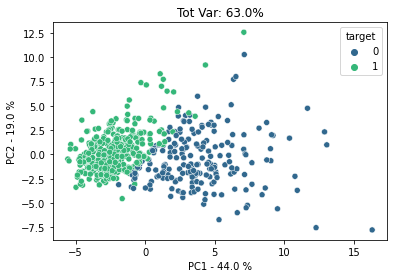

In [272]:
sns.scatterplot(x=Y[0], y=Y[1], hue=y, palette='viridis')
plt.xlabel(f'PC1 - {np.round(var_exp[0],0)} %')
plt.ylabel(f'PC2 - {np.round(var_exp[1],0)} %')
plt.title(f'Tot Var: {np.round(cum_var_exp[1],0)}%');

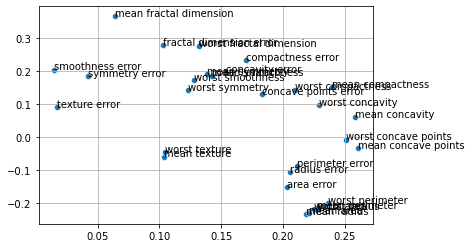

In [278]:
sns.scatterplot(x=matrix_w[:,0],y=matrix_w[:,1])
plt.grid()
for col in range(len(X.columns)):
    text = X.iloc[:,col].name
    plt.annotate(text,(matrix_w[col,0],matrix_w[col,1]))

In [252]:
%timeit eig_vals, eig_vecs = np.linalg.eig(np.cov(X_std.T))

684 µs ± 60.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [253]:
%timeit u, s, vh = np.linalg.svd(X_std,full_matrices=False)

460 µs ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [254]:
%timeit u, s, vh = np.linalg.svd(X_std,full_matrices=True)

7.09 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [255]:
%timeit s = np.linalg.svd(X_std,full_matrices=True, compute_uv=False)

282 µs ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [224]:
# flip eigenvectors' sign to enforce deterministic output
# Adjusts the columns of u and the rows of v such that the loadings in the
# columns in u that are largest in absolute value are always positive.
max_abs_cols = np.argmax(np.abs(u), axis=0)
signs = np.sign(u[max_abs_cols, range(u.shape[1])])
u *= signs
vh *= signs[:, np.newaxis]

In [256]:
s #singular values

array([86.93235745, 56.90677266, 40.04263937, 33.57058877, 30.62887007,
       26.2104161 , 19.60102663, 16.46800391, 15.4017255 , 14.12602481,
       12.93205441, 12.19019359, 11.71889139,  9.4519063 ,  7.31866075,
        6.74106325,  5.81360925,  5.47175363,  5.30591648,  4.21066503,
        4.12971871,  3.95133143,  3.72155031,  3.20519874,  2.96796958,
        2.15709923,  1.98150547,  0.95096438,  0.65273958,  0.27514088])

In [257]:
explained_variance_ = (s ** 2) / (n_samples - 1)
total_var = explained_variance_.sum()
explained_variance_ratio_ = explained_variance_ / total_var
g1_mask = explained_variance_ratio_>0.01

array([0.44272026, 0.18971182, 0.09393163, 0.06602135, 0.05495768,
       0.04024522, 0.02250734, 0.01588724, 0.01389649, 0.01168978])

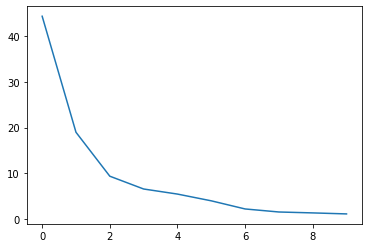

In [297]:
plt.plot(explained_variance_ratio_[g1_mask]*100)
explained_variance_ratio_[g1_mask]

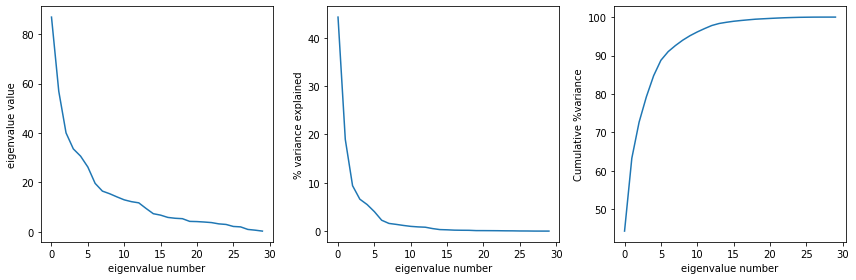

In [259]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(s)
plt.xlabel('eigenvalue number')
plt.ylabel('eigenvalue value')
plt.subplot(1,3,2)
plt.plot(100*explained_variance_ratio_)
plt.xlabel('eigenvalue number')
plt.ylabel('% variance explained')
plt.subplot(1,3,3)
plt.plot(np.cumsum(100*explained_variance_ratio_))
plt.xlabel('eigenvalue number')
plt.ylabel('Cumulative %variance')
plt.tight_layout(); 

In [260]:
len(explained_variance_ratio_[g1_mask]), len(explained_variance_ratio_)

(10, 30)

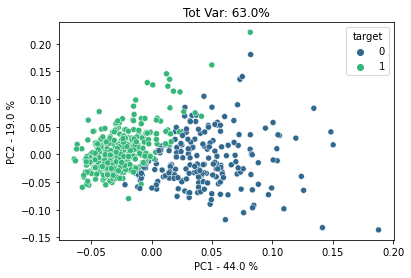

In [274]:
sns.scatterplot(x=-u[:,0],y=-u[:,1], hue=y, palette='viridis')
plt.xlabel(f'PC1 - {np.round(100*explained_variance_ratio_[0],0)} %')
plt.ylabel(f'PC2 - {np.round(100*explained_variance_ratio_[1],0)} %')
plt.title(f'Tot Var: {np.round(np.cumsum(100*explained_variance_ratio_)[1],0)}%');

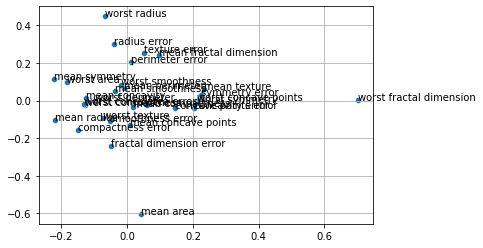

In [279]:
sns.scatterplot(x=vh[:,0],y=vh[:,1])
plt.grid()
for col in range(len(X.columns)):
    text = X.iloc[:,col].name
    plt.annotate(text,(vh[col,0],vh[col,1]))

## SKLEARN PCA

In [280]:
from sklearn.decomposition import PCA

In [289]:
pca = PCA(n_components=6,svd_solver='auto')

In [290]:
scores = pca.fit_transform(X_std) # u

In [291]:
%timeit scores = pca.fit_transform(X_std) # u

2.79 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<AxesSubplot:>

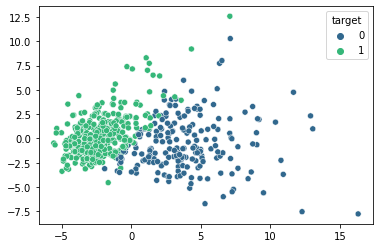

In [292]:
sns.scatterplot(x=scores[:,0],y=scores[:,1], hue=y, palette='viridis')

array([44.27202561, 18.97118204,  9.39316326,  6.60213492,  5.49576849,
        4.02452204])

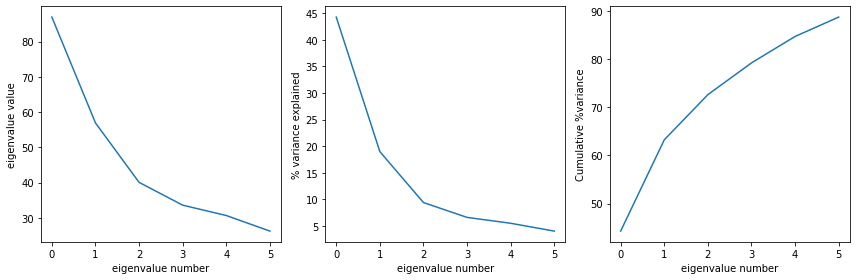

In [296]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(pca.singular_values_)
plt.xlabel('eigenvalue number')
plt.ylabel('eigenvalue value')
plt.subplot(1,3,2)
plt.plot(100*pca.explained_variance_ratio_)
plt.xlabel('eigenvalue number')
plt.ylabel('% variance explained')
plt.subplot(1,3,3)
plt.plot(np.cumsum(100*pca.explained_variance_ratio_))
plt.xlabel('eigenvalue number')
plt.ylabel('Cumulative %variance')
plt.tight_layout(); 
pca.explained_variance_ratio_*100

In [298]:
print(pca.singular_values_) # s

[86.93235745 56.90677266 40.04263937 33.57058877 30.62887007 26.2104161 ]


In [299]:
pca.explained_variance_ratio_.sum()

0.8875879635668981

In [300]:
from sklearn.model_selection import cross_val_score

## scores

In [24]:
# X = TP + E
E1 = X_std - scores@pca.components_
fscore1 = np.sum(np.sum(E1**2))
E2 = X_std - pca.inverse_transform(scores)
fscore2 = np.sum(np.sum(E2**2))
f_pca_score = pca.score(X_std)
E3 = X_std - np.dot(scores,pca.components_)
fscore3 = np.sum(np.sum(E3**2, axis=1))

In [25]:
fscore1, fscore2, fscore3, f_pca_score

(3537.7586075152503, 3537.75860751525, 3537.7586075152494, -26.987571919103107)

In [26]:
cross_val_score(pca,X_std).mean(),cross_val_score(pca,X_std).std()

(-28.439529112798063, 3.2909648273665515)

In [27]:
def myscore(X_train,scores,pca):
    # X = TP + E
    E1 = X_train - scores@pca.components_
    fscore1 = np.sum(np.sum(E1**2))
    return fscore1

In [28]:
from sklearn.decomposition import FactorAnalysis

In [29]:
df = pd.DataFrame(columns=['components','explained_variance','smallest_var_ratio','train_score','test_score','pca_train_score','pca_test_score','std_train','std_test'])
df = pd.DataFrame(columns=['components','explained_variance','smallest_var_ratio','pca_scores','fa_scores'])
for comp in range(1,20):
    fa = FactorAnalysis(n_components = comp)
    pca = PCA(n_components=comp,svd_solver='auto',random_state=42)
    scores = pca.fit_transform(X_std) # u
    exp_var = pca.explained_variance_ratio_.sum()
    smallest_contrib = pca.explained_variance_ratio_[-1]
    pca_scores=(np.mean(cross_val_score(pca,X_std)))
    fa_scores=(np.mean(cross_val_score(fa, X_std)))
    
    df.loc[len(df)] = [comp,exp_var,smallest_contrib,pca_scores,fa_scores]

In [30]:
df.head(1)

,components,explained_variance,smallest_var_ratio,pca_scores,fa_scores
0,1.0,0.44272,0.44272,-36.426396,-31.796325


In [31]:
np.argmax(df.pca_scores)

18

In [32]:
np.argmax(df.fa_scores)

17

In [33]:
n_components_pca = np.argmax(df.pca_scores)
n_components_fa = np.argmax(df.fa_scores)

<AxesSubplot:xlabel='components', ylabel='pca_scores'>

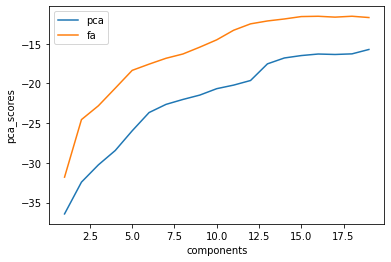

In [34]:
sns.lineplot(x='components',y='pca_scores',data=df,label='pca')
sns.lineplot(x='components',y='fa_scores',data=df,label='fa')
#plt.yscale('log')